## Changelog:

* v8 Checking code and revising the debug files. Ready for debugging 
* V9 Adding resampling
* V10 Adding tensorboard
* V11 Reducing LSTM layer to 1 in order to have better interpretation in tensorboard
* V12 adding actionId to data in order to debug datasets and step better + fixing the wrong column name for x_prepared + **fixing LABEL WRONG!!!!! ASSIENMENT **
* V13 removing masking layer and padding with 0 or 9999
* V14 removing two outputs
* V15 returning the masking layer with mask value 99.
    - The result is that without adding masking layer the training accuracy does not increase at all and it remains the same on nearly 50
    - however the validation accuracy remains the same around 50 and does not increase while the validation loss is being increased as allways
* V16 Changing the optimizer to SGD
* V17 Changing the optimizer to rmsprop
* V18 Increasing batch size from 1 to higher and coming back the optimizer to Adam (both roc and accuracy on train was about .9 while the accuracy of validation was 0.5
* V19 Separating validation set from data and feed to the fit function using validation_data param
* V20 Adding another layer of 100 unit
* V21 Joining per stud features
* V22 removing the sampling
* V23 Add two output
* V24 Assumes that we are overfitting so we are going to:
    - Remove additional LSTM layer to simplify the model $\checkmark$
    - Reduce the number of units for LSTM layer $\checkmark$ (saw that finally validation loss starts to deacrease with 20 unit and 200 seq lenght)
    - Reduce the number of features as much as possible (should be done after dinormalizing the binary variables)
    - Reduce the number of seq length $\checkmark$
* V25 Excluding binary variables and some other proportional variables from the standardization step (it seems we are improving!)
* V26 Adding competition validation set for making prediction on un-labeled data

In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from keras import optimizers
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# pandas.set_option('max_columns',10)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
pre = Preprocessing()
_,_ = pre.load_data(time_gap=200)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [4]:
per_action_dataset = pre.per_action_dataset
per_action_dataset.index = per_action_dataset.ITEST_id

per_action_dataset = pre.per_action_dataset.drop(['ITEST_id', 'assistmentId', 'problemId', 'assignmentId'], axis=1)

In [5]:
per_stud_dataset = pre.per_stud_dataset.drop("isSTEM", axis=1)
per_stud_dataset.index = per_stud_dataset.ITEST_id
per_stud_dataset = per_stud_dataset.drop("ITEST_id", axis=1)
dataset = per_stud_dataset.join(per_action_dataset)
dataset.index = pd.MultiIndex.from_arrays([dataset.index.values, dataset.actionId.values], names=["ITEST_id", "actionId"])
dataset = dataset.drop("actionId", axis=1)

In [6]:
test_dataset = pre.test_dataset.drop("ITEST_id", axis=1)
test_dataset.index = pre.test_dataset.ITEST_id

shared_ids_with_train = test_dataset.index.intersection(dataset.index.get_level_values(0).unique().values)
pure_testset = test_dataset.drop(shared_ids_with_train)
raw_dataset = pre.raw_dataset.drop(Cols.excluded_cols + ["ITEST_id"], axis=1)
raw_dataset.index = pre.raw_dataset.ITEST_id

included_cols = list(set(Cols.per_action_cols + Cols.per_stud_cols).difference(set(['isSTEM', 'assistmentId', 'problemId', 'assignmentId'] + Cols.excluded_cols + Cols.per_stud_cols_cat + Cols.per_action_cols_cat)))
pure_testset_perActionAndStud = pure_testset.join(raw_dataset)[included_cols]
pure_testset_perActionAndStud.index = pd.MultiIndex.from_arrays([pure_testset_perActionAndStud.index.values,pure_testset_perActionAndStud.actionId.values ], names=["ITEST_id", "actionId"])
pure_testset_perActionAndStud = pure_testset_perActionAndStud.drop("actionId", axis=1)

In [7]:
dataset = pd.concat([dataset, pure_testset_perActionAndStud])

In [8]:
# defining sequence length (or number of time-steps) for each student and batch-size
max_length_seq = 500

In [9]:
# show the seq of a sample student (id =9)
#per_action_dataset[per_action_dataset.index.get_level_values(0) ==9].head()
# per_action_dataset.to_csv("Debug/1-per_action_dataset.csv")

In [10]:
# truncating seq of each student and only considering his last 'max_length_seq' actions based on startTime feature
truncated_input = dataset.sort_values("startTime",ascending=False).groupby('ITEST_id').head(max_length_seq)
# truncated_input.to_csv("Debug/2-truncated_input.csv")

In [11]:
# for excluding binary features from standardization process
binary_cols = ['AveKnow', 'AveCarelessness', 'correct', 'original', 'hint', 'scaffold', 'bottomHint', 'frIsHelpRequest', 'stlHintUsed', 'frWorkingInSchool',
               'responseIsFillIn', 'responseIsChosen', 'endsWithScaffolding', 'endsWithAutoScaffolding', 'frIsHelpRequestScaffolding', 'timeGreater5Secprev2wrong', 'helpAccessUnder2Sec', 'timeGreater10SecAndNextActionRight', 'timeOver80', 'manywrong']
should_not_normalize_cols = ['RES_BORED', 'RES_CONCENTRATING', 'RES_CONFUSED', 'RES_FRUSTRATED', 'RES_OFFTASK', 'RES_GAMING']
# also for 'AveCorrect', AveResBored, AveResEngcon, AveResConf, AveResFrust, AveResOfftask, AveResGaming, , Ln-1, Ln, 
should_not_normalized = truncated_input[should_not_normalize_cols + binary_cols]
should_normalized = truncated_input.drop(should_not_normalize_cols + binary_cols, axis =1)

In [12]:
# scaling dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(should_normalized)
scaled_data = DataFrame(scaled_data, index=should_normalized.index, columns=should_normalized.columns)
X_scaled = scaled_data.join(should_not_normalized)

# X_scaled[X_scaled.index.get_level_values(0) ==9].head()
# X_scaled.to_csv("Debug/3-X_scaled.csv")

In [13]:
# fig, ax = plt.subplots()  # create figure & 1 axis
# X_scaled.boxplot(X_scaled.columns.difference(["startTime", 'endTime']).values.tolist(),ax=ax)
# fig.set_size_inches(100,100)
# fig.savefig('X_scaled.png')   # save the figure to file
# plt.close(fig) 

In [14]:
batch_size=1

In [15]:
# padding sequences to have a same length
X_padded = []
for stud_id, stud_seq in X_scaled.groupby('ITEST_id'):
    X_padded.append(stud_seq)
X_padded = sequence.pad_sequences(X_padded, max_length_seq, dtype='float64', padding="post", truncating="post", value=99.)

In [16]:
# getting a sense about padded dataset
ITEST_ix = pd.Index(np.repeat(sorted(X_scaled.index.get_level_values(0).unique()), max_length_seq), name='ITEST_id')
new_seq_ix = pd.Index(list(range(0,max_length_seq))* X_padded.shape[0], name="seq_ix")
paddedData = DataFrame(X_padded.reshape(X_padded.shape[0]*X_padded.shape[1], -1), index=[ITEST_ix, new_seq_ix], columns=X_scaled.columns)
# paddedData.to_csv("Debug/4-paddedData.csv")

In [17]:
# creating label dataset with index as ITEST_id values
label_dataset = pre.label_dataset[['ITEST_id', 'isSTEM']]
label_dataset.index = label_dataset.ITEST_id
label_dataset = label_dataset.drop("ITEST_id", axis = 1)
#label_dataset

In [18]:
# separating unlabeled data from labeled data and preparing competition data for prediction
X_competition = paddedData.loc[pure_testset.index.unique().values, :]
paddedData = paddedData.drop(pure_testset.index.unique().values)
X_competition_arr = X_competition.values.reshape(-1, max_length_seq, X_competition.shape[1])

In [19]:
# join label with dataset to make sure we have a consistent dataset
# (of course before the training the label column will be droped from data)
X_with_label = paddedData.join(label_dataset)
#print(X_with_label.shape)
# X_with_label.to_csv("Debug/5-X_with_label.csv")

In [20]:
# from sklearn.utils import resample

# df_majority = X_with_label[X_with_label['isSTEM'] == 0]
# df_minority = X_with_label[X_with_label['isSTEM'] == 1]

# minority_len = len(df_minority.index.get_level_values(0).unique())
# majority_len = len(df_majority.index.get_level_values(0).unique())

# sampled_df_majority = df_majority.loc[resample(df_majority.index.get_level_values(0).unique(), n_samples=minority_len, replace=False).values]

# balanced_X = pd.concat([df_minority, sampled_df_majority])

In [22]:
y_prepared = X_with_label[~X_with_label.index.get_level_values(0).duplicated()]['isSTEM'].values
X_prepared = X_with_label.drop("isSTEM", axis=1)
X_prepared_columns = X_prepared.columns
X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))
# DataFrame(X_prepared.reshape(X_prepared.shape[0] * X_prepared.shape[1], X_prepared.shape[2]), index=X_with_label.index, columns=X_prepared_columns).to_csv("Debug/6-X_prepared.csv")

#for balanced dataset only 
# y_prepared = balanced_X[~balanced_X.index.get_level_values(0).duplicated()]['isSTEM'].values
# X_prepared = balanced_X.drop("isSTEM", axis=1)
# X_prepared_columns = X_prepared.columns
# X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))

# DataFrame(X_prepared.reshape(X_prepared.shape[0] * X_prepared.shape[1], X_prepared.shape[2]), index=balanced_X.index, columns=X_prepared_columns).to_csv("Debug/6-X_prepared.csv")

## Model

In [23]:
from keras.layers import Masking

def create_LSTM_model(max_length_seq, feature_size):
    model = Sequential()
    model.add(Masking(mask_value=99., input_shape=(max_length_seq, feature_size)))
    model.add(LSTM(256))
    model.add(Dense(2, activation='softmax'))
#   sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

In [24]:
# splitting train/test data 
X_train, X_test, y_train,y_test = train_test_split(X_prepared,y_prepared, train_size=.77)
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

In [25]:
from keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=batch_size, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [26]:
# Create model
model = create_LSTM_model(max_length_seq, X_train.shape[2])
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data= (X_test,y_test), callbacks=[tensorboard_callback])

Train on 359 samples, validate on 108 samples
Epoch 1/20
359/359 [==============================] - 181s 503ms/step - loss: 0.6375 - acc: 0.7298 - val_loss: 0.5834 - val_acc: 0.7130
Epoch 2/20
359/359 [==============================] - 178s 497ms/step - loss: 0.5588 - acc: 0.7465 - val_loss: 0.5729 - val_acc: 0.7407
Epoch 3/20
359/359 [==============================] - 178s 496ms/step - loss: 0.5361 - acc: 0.7437 - val_loss: 0.5466 - val_acc: 0.7500
Epoch 4/20
359/359 [==============================] - 178s 495ms/step - loss: 0.5374 - acc: 0.7521 - val_loss: 0.5453 - val_acc: 0.7500
Epoch 5/20
359/359 [==============================] - 178s 495ms/step - loss: 0.5014 - acc: 0.7716 - val_loss: 0.5625 - val_acc: 0.7407
Epoch 6/20
359/359 [==============================] - 178s 496ms/step - loss: 0.4680 - acc: 0.7855 - val_loss: 0.5952 - val_acc: 0.7315
Epoch 7/20
359/359 [==============================] - 178s 497ms/step - loss: 0.4515 - acc: 0.7855 - val_loss: 0.5986 - val_acc: 0.7130
Ep

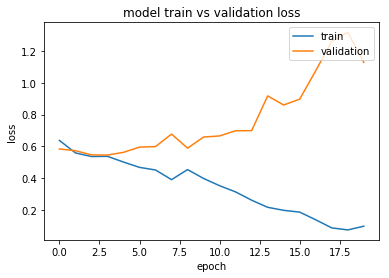

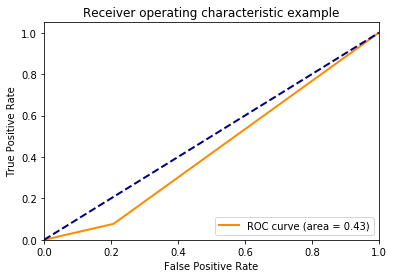

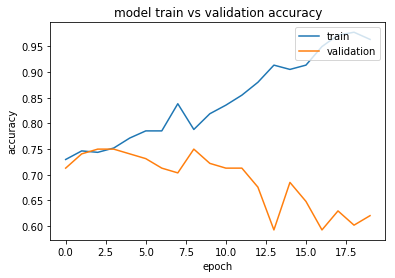

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 500, 52)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               316416    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 316,930
Trainable params: 316,930
Non-trainable params: 0
_________________________________________________________________
None
Test ROC Score: 0.516886
Test RMSE Score: 0.522343
Final Competition Score: 0.994543


In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from Vis import plot_accuracy
# do prediction
y_pred = model.predict(X_test, batch_size=batch_size)

# calculating scores
roc_score = roc_auc_score(y_test, y_pred)
# roc_score = roc_auc_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))

mse_score = mean_squared_error(y_test, y_pred)

#printing and plotting model and score information
plot_loss(history)
# plot_roc(y_test, y_pred)
plot_roc(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))

In [28]:
# y_pred_competition = model.predict(X_competition_arr, batch_size=batch_size)

# result_index = X_competition.reset_index(level=1, drop=True).index.unique()

# argmax_preds = [np.argmax(predicted_label) for predicted_label in y_pred_competition]

# result_df = DataFrame(argmax_preds, index=pd.Index(result_index, name='ITEST_id'), columns=['isSTEM'])

# final_output = pd.concat([result_df, label_dataset.loc[shared_ids_with_train.values]]).sort_index()
# final_output.to_csv("submition_3_{}.csv".format(theNotebook))
# final_output.isSTEM.value_counts()